### Author: Helen Cai
### April 2025
The purpose of this notebook is to create a decoder architecture that will be used in our final project.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import Linear
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import tqdm

# NetworkX is a Python package used to create, manipulate, and mine graphs
import networkx as nx

# further libraries for working with graphs
import torch_geometric
from torch_geometric.nn import GCNConv, pool
from torch_geometric.utils import to_networkx
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader

# For visualization
import phate

from functions.utils import *

## Hyperparameters

In [2]:
batch_size = 1
learning_rate = 1e-3
epochs = 5
p = 0.2     # probability for dropout
regularization_lambda = 0.1 # for L0 regularization

## 0. Import data, get latent space embeddings

In [3]:
hidden_values = torch.load("./data/hidden_values_from_insecticides.pt", weights_only=False)
insecticides = torch.load("./data/insecticides_graphs_small.pt", weights_only=False)

# note that logP values are in the y slot of the data


Because the value of D changes for each of the graphs in our dataset, we need some way to account for this. I will allow the decoding MLP to project to a size of fixed dimension, (e.g. the dimension that corresponds to the largest possible graph). Then, in my training dataset, the graphs will be padded with 0's to match the resulting dimension. 

In [4]:
# Function to add padding to target matrices to match the output dimensions
def pad_graphs(input_x, input_edge_index, input_edge_attr, D = 88):
    extra_x = int((D/2) - input_x.shape[0])
    padded_x = F.pad(input_x, (0, 0, 0, extra_x), value=0)

    extra_edge_index = int(D - input_edge_index.shape[1])
    padded_edge_index = F.pad(input_edge_index, (0, extra_edge_index, 0, 0), value=0)

    extra_edge_attr = int(88 - input_edge_attr.shape[0])
    padded_edge_attr = F.pad(input_edge_attr, (0, 0, 0, extra_edge_attr), value=0)

    return padded_x, padded_edge_index, padded_edge_attr


In [5]:
# Function to reshape the edge index representation into an adjacency matrix
def reshape_index(input_index, D=88+1):
    adj = np.zeros((D,D))
    for pair in input_index.T:
        i = pair[0].numpy()
        j = pair[1].numpy()
        adj[i, j] = 1
    adj = adj[1:D, 1:D]
    return torch.tensor(adj)

In [6]:
# Add the hidden values to the graphs & add padding
y_values_list = []

for i in range(len(insecticides)):
    graph = insecticides[i]
    graph.hidden_values = hidden_values[i]
    graph.x, graph.edge_index, graph.edge_attr = pad_graphs(graph.x, graph.edge_index, graph.edge_attr)
    y_values_list.append(graph.y)
    graph.edge_index = reshape_index(graph.edge_index)

Calculating PHATE...
  Running PHATE on 625 observations and 32 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.07 seconds.
    Calculating affinities...
  Calculated graph and diffusion operator in 0.09 seconds.
  Calculating optimal t...


/home/hsc26/.conda/envs/cpsc_452/lib/python3.12/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 79 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Automatically selected t = 16
  Calculated optimal t in 46.69 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.05 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 0.20 seconds.
Calculated PHATE in 47.08 seconds.


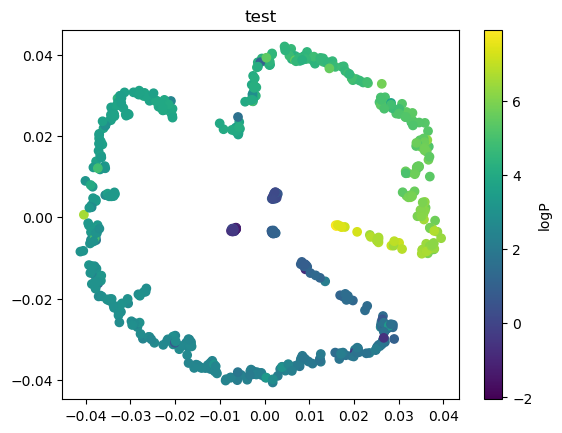

In [7]:
# apply PHATE with hidden values
phate_operator = phate.PHATE()
Y_phate = phate_operator.fit_transform(hidden_values)
plt.scatter(x = Y_phate[:,0], 
            y = Y_phate[:,1],
            c = y_values_list, cmap = 'viridis')
plt.colorbar(label="logP")
plt.title("test")
plt.show()

In [8]:
# Create dataloaders 
# split into training and test
train_dataset, test_dataset = train_test_split(insecticides, test_size=0.2, random_state=2025)

all_data = DataLoader(insecticides, batch_size=1, shuffle = False)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## 1. Training a latent space decoder

Now that we have accomplished diffusion in the latent space, we want to be able to convert that latent space representation back to a graph representation. 

For our training process: our inputs are latent space points and the original graphs used to generate them. Refer to the `encoder` notebook for information on how these inputs are generated. 

We note that the graph data has the following (rough) dimensions: `x` $ \in R^{D\times3}$, `edge_index` $ \in R^{2 \times D}$, `edge_attr` $ \in R^{D \times 1}$. Thusly, these are the dimensions that our decoder will work to.


In [9]:
# What's the maximum number of edges we need to predict?
max([data.edge_index.shape[1] for data in insecticides])

88

In [10]:
class DecodeNet(nn.Module):
    """
    Initialize an MLP for re-creating graph representations from latent space.
    Input (x) will be latent space embeddings (tensor 32).
    We need to be able to predict x, edge_index, edge_attr.
    The number of nodes and edges will also be dynamically predicted.
    """
    def __init__(
        self,
        num_features: int = 32, # This is the size of the latent space representations.
        D: int = 88, # TODO figure this out
        p: float = 0.0,
    ):
        super().__init__()
        self.D = D

        # Use an MLP to expand dimensions of latent space
        self.mlp = nn.Sequential(
            Linear(num_features, 128),
            nn.ReLU(),
            Linear(128, 128),
            nn.ReLU()
        )
        
        # one head for predicting features x
        x_dim = int(D * 3 / 2)
        self.x_fc = nn.Sequential(
            Linear(128, 128),
            nn.ReLU(),
            Linear(128, 64),
            nn.ReLU(),
            Linear(64, x_dim))

        # one head for predicting edge_index
        self.edge_index_fc = nn.Sequential(
            Linear(128, 64),
            nn.ReLU(),
            Linear(64, 128),
            nn.ReLU(),
            Linear(128, D*D),
            nn.Sigmoid())

        # one head for predicting edge_attr
        self.edge_attr_fc = nn.Sequential(
            Linear(128, 128),
            nn.ReLU(),
            Linear(128, 64),
            nn.ReLU(),
            Linear(64, 1*D))


    def forward(self, data):
        
        # Apply the MLP
        h = self.mlp(data)
        
        # Predict x and reshape
        x = self.x_fc(h)
        x = x.view(-1, int(self.D / 2), 3)
        x = torch.squeeze(x, 0)

        # Predict edge_index and reshape
        edge_index = self.edge_index_fc(h)
        edge_index = edge_index.view(self.D, self.D)
        edge_index = torch.squeeze(edge_index, 0)

        # Predict edge_attr and reshape
        edge_attr = self.edge_attr_fc(h)
        edge_attr = edge_attr.view(-1, self.D, 1)
        edge_attr = torch.squeeze(edge_attr, 0)

        return x, edge_index, edge_attr 

We should be thoughtful about how we calculate loss for each of these 3 different things. 

* for x (node features): these are floats, so we can compare them using MSE loss
* for edge_index: these are categorical, so we should use a categorical-type loss such as  cross entropy
* for edge_attr: these are also floats, so we can use MSE loss

In [11]:
def train_decoder_epoch(model, optimizer, train_loader):
    """Train the model for one epoch.
    Args:
        model: the model
        optimizer: the optimizer
        train_loader: contains all information needed for training, including graphs and their latent space representations.
    Returns:
        train_loss: the loss of the epoch
    """
    
    model.train()
    optimizer.zero_grad()
    loss_epoch = 0

    # what loss functions are used for each of our three targets?
    x_criterion = nn.MSELoss()
    edge_index_criterion = nn.BCELoss()  # TODO: think about cross entropy loss here?
    edge_attr_criterion = nn.MSELoss()
    
    # evaluate on the train nodes
    for data in train_loader:
        target_x = data.x
        target_edge_index = data.edge_index
        target_edge_attr = data.edge_attr
        
        batch_size = data.num_graphs

        # get the outputs
        x, edge_index, edge_attr  = model(data.hidden_values)

        # calculate loss for each of the three outputs
        x_loss = x_criterion(x, target_x)
        edge_index_loss = edge_index_criterion(edge_index.to(torch.float), target_edge_index.to(torch.float))  ## something strange w data types here
        edge_attr_loss = edge_attr_criterion(edge_attr, target_edge_attr)

        # calculate L1 regularization loss
        l1_norm = sum(torch.sum(torch.abs(param)) for param in model.parameters())
        
        # aggregate the total loss
        loss = x_loss + edge_index_loss + edge_attr_loss + regularization_lambda * l1_norm

        loss.backward()
        loss_epoch += loss.detach().numpy() * batch_size

        optimizer.step()

    # calculate training loss for the epoch
    loss_epoch = loss_epoch / len(train_loader.dataset)

    return loss_epoch 
    

In [12]:
def test_decoder_epoch(model, train_loader):
    """Test the model for one epoch.
    Args:
        model: the model
        train_loader: contains all information needed for training, including graphs and their latent space representations.
    Returns:
        train_loss: the loss of the epoch
    """
    model.eval()  # set model to evaluation mode

    loss_epoch = 0
    
    # what loss functions are used for each of our three targets?
    x_criterion = nn.MSELoss()
    edge_index_criterion = nn.BCELoss()  # TODO: think about cross entropy loss here?
    edge_attr_criterion = nn.MSELoss()
    
    with torch.no_grad():  # disable gradient calculation

        for data in train_loader:
            target_x = data.x
            target_edge_index = data.edge_index
            target_edge_attr = data.edge_attr
            
            batch_size = data.num_graphs
    
            # get the outputs
            x, edge_index, edge_attr  = model(data.hidden_values)
    
            # calculate loss for each of the three outputs
            x_loss = x_criterion(x, target_x)
            edge_index_loss = edge_index_criterion(edge_index.to(torch.float), target_edge_index.to(torch.float))  ## something strange w data types here
            edge_attr_loss = edge_attr_criterion(edge_attr, target_edge_attr)
            
            # calculate L1 regularization loss
            l1_norm = sum(torch.sum(torch.abs(param)) for param in model.parameters())
            
            # aggregate the total loss
            loss = x_loss + edge_index_loss + edge_attr_loss + regularization_lambda * l1_norm
         
            loss_epoch += loss.detach().numpy() * batch_size

        # calculate test loss for the epoch
        loss_epoch = loss_epoch / len(test_loader.dataset)
                
    return loss_epoch

In [13]:
def train_decoder(model, train_loader, test_loader, optimizer, epochs=5):
    """Train the model.
    Args:
        model: the model
        loss_fn: the loss function
        train_loader: the training data loader
        test_loader: the testing data loader
        optimizer: the optimizer
        epochs: the number of epochs to train
    Returns:
        train_losses: the training losses
        test_losses: the testing losses
    """
    train_losses = []
    
    test_losses = []
    
    loop = tqdm.tqdm(range(1, epochs + 1))

    for epoch in loop:

        # train the model for one epoch
        train_loss_epoch = train_decoder_epoch(model, optimizer, train_loader)
        
        # test the model for one epoch        
        test_loss_epoch = test_decoder_epoch(model, train_loader)

        # put into our storage vectors
        train_losses.append(train_loss_epoch)
        test_losses.append(test_loss_epoch)
        
        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(train_loss=train_loss_epoch, test_loss=test_loss_epoch)
    
    return train_losses, test_losses

In [14]:
decoder = DecodeNet(p = p)

# Define the optimizer
optimizer = torch.optim.RMSprop(decoder.parameters(), lr = learning_rate)

# Call the functions
decoder_train_losses, decoder_test_losses  = train_decoder(decoder, train_loader, test_loader, optimizer, epochs=epochs)

Epoch 5: 100%|██████████| 5/5 [19:51<00:00, 238.25s/it, test_loss=1.67e+3, train_loss=310]


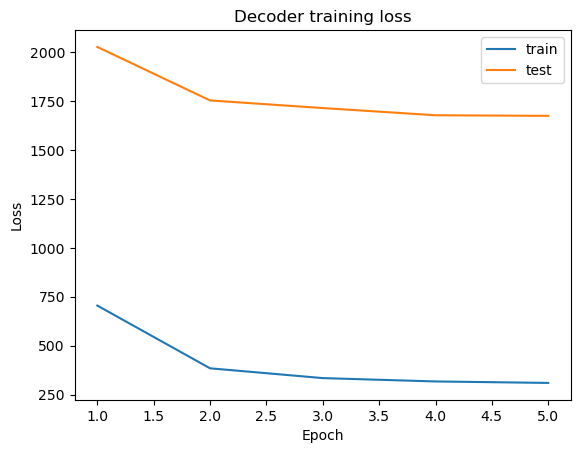

In [15]:
plot_metrics(decoder_train_losses, decoder_test_losses, 
             xlabel="Epoch", ylabel="Loss", title="Decoder training loss", 
             fname="test.png", subdir="./training-figs/decoder/")

In [16]:
decoder_train_losses

[705.0651447753906,
 384.4598244018555,
 334.3670984802246,
 317.24708123779294,
 309.72584420776366]

In [17]:
torch.save(decoder.state_dict(), "./models/decoder-trained.pth")

## 2. Generation: Going from latent space into graph space

Call the latent space decoder.

In [18]:
# load in the previously generated points (generated by the diffusion model
generated_new_points = torch.load("./data/generated_points.pt")

desired_logP_list = np.linspace(0, 2, 10)

decoder = DecodeNet()
decoder.load_state_dict(torch.load("./models/decoder-trained.pth"))


/tmp/ipykernel_1138268/2544811909.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generated_new_points = torch.load("./data/generated_points.pt")
/tmp/ipykernel_1138268/

<All keys matched successfully>

In [19]:
decoded_new_points = list(range(len(generated_new_points)))

for i in range(len(generated_new_points)):
    point = torch.tensor(generated_new_points[i])
    generated_x, generated_edge_index, generated_edge_attr = decoder(point) 

    decoded_new_points[i] = Data(y = desired_logP_list[i],
                                x = generated_x,
                                edge_index = generated_edge_index,
                                edge_attr = generated_edge_attr)

In [21]:
decoded_new_points[2].edge_index

tensor([[0.4976, 0.4988, 0.4999,  ..., 0.5004, 0.5002, 0.4983],
        [0.5013, 0.4994, 0.4984,  ..., 0.4977, 0.4984, 0.4969],
        [0.4998, 0.5012, 0.4978,  ..., 0.4999, 0.5004, 0.5024],
        ...,
        [0.4995, 0.5003, 0.4982,  ..., 0.5031, 0.5009, 0.5011],
        [0.5004, 0.5001, 0.4974,  ..., 0.4995, 0.4984, 0.5006],
        [0.4993, 0.4990, 0.4997,  ..., 0.5006, 0.5007, 0.5025]],
       grad_fn=<SqueezeBackward1>)

## 3. Export the graphs for evaluation 

This is where we pass things back to Tobias to work on for evaluation. 

In [20]:
torch.save(decoded_new_points, "./data/decoded_new_points.pth")